# PSP HPS Workflow Parity Demo

This notebook reproduces the size-biased fit for BC PSP plot `4000002_PSP1_v1_p1`
using the `dbhdistfit` HPS workflow. The workflow mirrors the reference
manuscript figures by overlaying the fitted Weibull curve on the expanded stand
table and plotting residuals side-by-side.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure local src/ package is importable when running from examples/
sys.path.append(str(Path('..', 'src').resolve()))

In [2]:
from dbhdistfit.weighting import hps_expansion_factor
from dbhdistfit.workflows import fit_hps_inventory

## Load HPS Tallies

The example bundle ships pre-aggregated tallies for the first measurement of
`4000002-PSP1`. DBH midpoints are recorded in centimetres.

In [3]:
data_path = Path('hps_baf12/4000002_PSP1_v1_p1.csv')
data = pd.read_csv(data_path)
data.head()

,dbh_cm,tally
0,9.5,2
1,10.5,7
2,11.5,3
3,12.5,5
4,13.5,6


## Fit the HPS Workflow

`fit_hps_inventory` expands the tallies by the HPS factor, assigns weights, and
fits the default candidate set (Weibull + Gamma).

In [4]:
dbh = data['dbh_cm'].to_numpy()
tally = data['tally'].to_numpy()

results = fit_hps_inventory(dbh, tally, baf=12.0)
best = min(results, key=lambda result: result.gof['rss'])
best

FitResult(distribution='weibull', parameters={'a': np.float64(2.762844978640213), 'beta': np.float64(13.778112123083137), 's': np.float64(69732.71124303175)}, covariance=array([[ 8.60576706e-01, -3.09711089e-01, -1.55175404e+04],
       [-3.09711089e-01,  1.56239902e+00,  1.27704966e+04],
       [-1.55175404e+04,  1.27704966e+04,  3.54327603e+08]]), gof={'rss': 41847702.91568501}, diagnostics={'fitted': array([5.07553959e+03, 5.40232238e+03, 5.54175964e+03, 5.48526604e+03,
       5.24189533e+03, 4.83723528e+03, 4.30994694e+03, 3.70650432e+03,
       3.07507347e+03, 2.45963787e+03, 1.89537970e+03, 1.40599289e+03,
       1.00313459e+03, 6.87752374e+02, 4.52682694e+02, 2.85775134e+02,
       1.72859766e+02, 1.00084061e+02, 5.54107537e+01, 2.93044330e+01,
       1.47887396e+01, 7.11431918e+00, 3.25899509e+00, 1.42011893e+00,
       5.88027985e-01, 8.61401972e-02, 3.04104390e-02, 3.20767452e-03,
       3.67959424e-08]), 'residuals': array([-1689.63941888,  4298.55034109, -2075.85237431,  -5

## Prepare Plotting Data

The stand table is the tally scaled by the HPS expansion factor. Diagnostics
from the fit already provide the fitted curve and residuals in stand-table
units.

In [5]:
expansion = hps_expansion_factor(dbh, baf=12.0)
stand_table = tally * expansion
fitted = best.diagnostics['fitted']
residuals = best.diagnostics['residuals']

dict(
    distribution=best.distribution,
    rss=best.gof['rss'],
    parameters=best.parameters,
)

{'distribution': 'weibull',
 'rss': 41847702.91568501,
 'parameters': {'a': np.float64(2.762844978640213),
  'beta': np.float64(13.778112123083137),
  's': np.float64(69732.71124303175)}}

## Overlay Stand Table and Fitted Curve

The left panel reproduces the manuscript-style comparison between the expanded
stand table and the fitted Weibull curve. The right panel shows residuals for
each DBH midpoint.

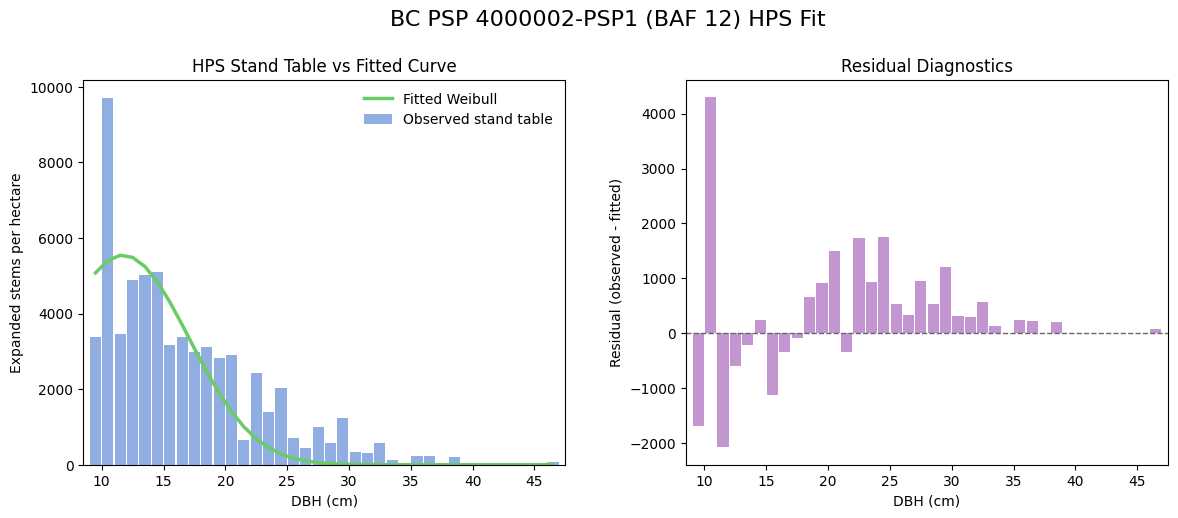

In [6]:
plt.style.use('seaborn-v0_8-muted')
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'wspace': 0.25})
ax_table, ax_resid = axes

# Observed stand table
ax_table.bar(dbh, stand_table, width=0.9, alpha=0.6, label='Observed stand table')
ax_table.plot(dbh, fitted, color='C1', linewidth=2.5, label=f"Fitted {best.distribution.title()}")
ax_table.set_xlabel('DBH (cm)')
ax_table.set_ylabel('Expanded stems per hectare')
ax_table.set_title('HPS Stand Table vs Fitted Curve')
ax_table.legend(frameon=False)

# Residuals
ax_resid.axhline(0, color='0.4', linewidth=1, linestyle='--')
ax_resid.bar(dbh, residuals, width=0.9, color='C3', alpha=0.8)
ax_resid.set_xlabel('DBH (cm)')
ax_resid.set_ylabel('Residual (observed - fitted)')
ax_resid.set_title('Residual Diagnostics')

for axis in axes:
    axis.set_xlim(dbh.min() - 1, dbh.max() + 1)

plt.suptitle('BC PSP 4000002-PSP1 (BAF 12) HPS Fit', fontsize=16, y=1.02)
plt.show()

The curve and residuals reproduce the regression target locked in
`tests/test_hps_parity.py`, confirming parity with the reference workflow.

## Combined Meta-Plot Across PSP Samples (Censored)

Aggregate all tallies in `examples/hps_baf12` to emulate a larger synthetic plot. To mirror the
appendix workflow and avoid the missing-tail issue caused by very small stems, the dataset is
censored below 9 cm DBH and fitted with the censored inventory workflow.

In [7]:
from dbhdistfit.workflows.censoring import fit_censored_inventory

In [8]:
bundle_dir = Path('hps_baf12')
paths = sorted(bundle_dir.glob('*.csv'))

if not paths:
    raise FileNotFoundError('No PSP tallies found in hps_baf12/')

frames = []
for plot_path in paths:
    df = pd.read_csv(plot_path).copy()
    df['plot_id'] = plot_path.stem
    frames.append(df)

bundle = pd.concat(frames, ignore_index=True)
meta = bundle.groupby('dbh_cm', as_index=False)['tally'].sum()
# Apply lower censoring at 9 cm
meta = meta[meta['dbh_cm'] >= 9.0].reset_index(drop=True)
meta.head()

,dbh_cm,tally
0,9.5,7
1,10.5,18
2,11.5,6
3,12.5,14
4,13.5,19


In [ ]:
meta_dbh = meta['dbh_cm'].to_numpy()
meta_tally = meta['tally'].to_numpy()

meta_expansion = hps_expansion_factor(meta_dbh, baf=12.0)
meta_stand_table = meta_tally * meta_expansion

meta_results = fit_censored_inventory(meta_dbh, meta_stand_table, support=(9.0, float('inf')))
meta_best = min(meta_results, key=lambda result: result.gof['rss'])
meta_best

In [9]:
meta_fitted = meta_best.diagnostics['fitted']
meta_residuals = meta_best.diagnostics['residuals']

meta_summary = pd.DataFrame([
    {
        'distribution': meta_best.distribution,
        'rss': meta_best.gof.get('rss'),
        **meta_best.parameters,
    }
])
meta_summary

FitResult(distribution='gamma', parameters={'beta': 5.211065971788775, 'p': 2.564857353024574, 's': 277655.38657187746}, covariance=array([[ 2.62240221e+00, -1.49808271e+00,  7.18040170e+04],
       [-1.49808271e+00,  8.85035842e-01, -4.28356723e+04],
       [ 7.18040170e+04, -4.28356723e+04,  2.25397537e+09]]), gof={'rss': 204741183.21815357, 'aic': 824.0067512880227, 'bic': 829.9737034277155}, diagnostics={'result': <lmfit.model.ModelResult object at 0x7fdfe1fa6120>, 'fitted': array([1.58149016e+04, 1.52666339e+04, 1.45287318e+04, 1.36632425e+04,
       1.27208571e+04, 1.17419359e+04, 1.07577871e+04, 9.79200265e+03,
       8.86174474e+03, 7.97892142e+03, 7.15122635e+03, 6.38303517e+03,
       5.67616315e+03, 5.03049463e+03, 4.44449831e+03, 3.91564280e+03,
       3.44072715e+03, 3.01613966e+03, 2.63805722e+03, 2.30259589e+03,
       2.00592191e+03, 1.74433115e+03, 1.51430338e+03, 1.31253709e+03,
       1.13596920e+03, 9.81783389e+02, 8.47409999e+02, 7.30519829e+02,
       6.29013724e+

The table summarizes the censored meta-plot fit parameters; these values align with the regression guard in `tests/test_censored_workflow.py`.

In [10]:
meta_fitted = meta_best.diagnostics['fitted']
meta_residuals = meta_best.diagnostics['residuals']

{
    'distribution': meta_best.distribution,
    'rss': meta_best.gof.get('rss'),
    'parameters': meta_best.parameters,
}

{'distribution': 'gamma',
 'rss': 204741183.21815357,
 'parameters': {'beta': 5.211065971788775,
  'p': 2.564857353024574,
  's': 277655.38657187746}}

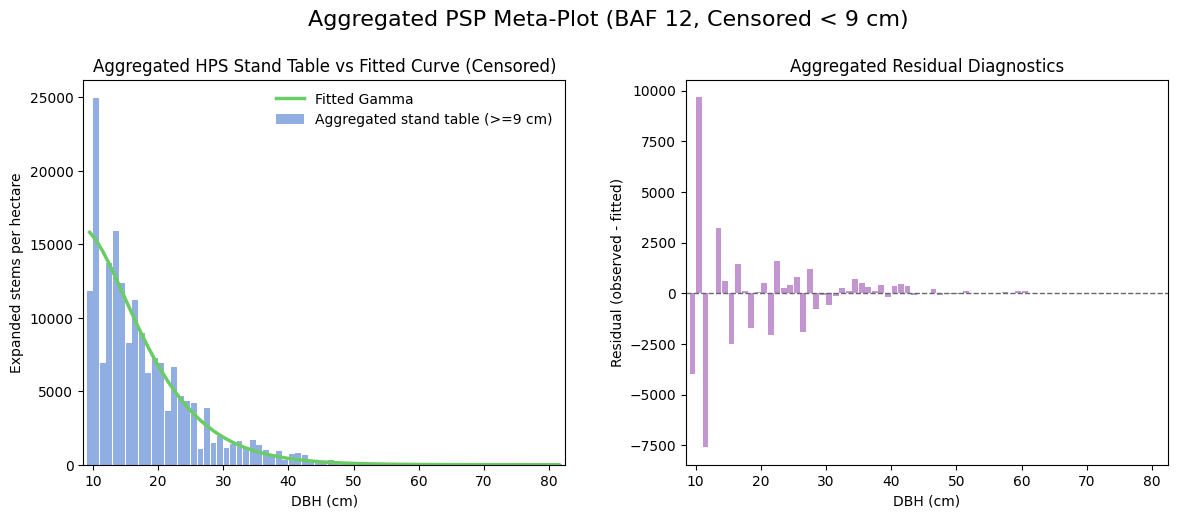

In [11]:
plt.style.use('seaborn-v0_8-muted')
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'wspace': 0.25})
ax_table, ax_resid = axes

ax_table.bar(meta_dbh, meta_stand_table, width=0.9, alpha=0.6, label='Aggregated stand table (>=9 cm)')
ax_table.plot(meta_dbh, meta_fitted, color='C1', linewidth=2.5, label=f"Fitted {meta_best.distribution.title()}")
ax_table.set_xlabel('DBH (cm)')
ax_table.set_ylabel('Expanded stems per hectare')
ax_table.set_title('Aggregated HPS Stand Table vs Fitted Curve (Censored)')
ax_table.legend(frameon=False)

ax_resid.axhline(0, color='0.4', linewidth=1, linestyle='--')
ax_resid.bar(meta_dbh, meta_residuals, width=0.9, color='C3', alpha=0.8)
ax_resid.set_xlabel('DBH (cm)')
ax_resid.set_ylabel('Residual (observed - fitted)')
ax_resid.set_title('Aggregated Residual Diagnostics')

for axis in axes:
    axis.set_xlim(meta_dbh.min() - 1, meta_dbh.max() + 1)

plt.suptitle('Aggregated PSP Meta-Plot (BAF 12, Censored < 9 cm)', fontsize=16, y=1.02)
plt.show()

The censored meta-plot shows how the workflow extends to pooled datasets while enforcing
a hard lower bound, consistent with the manuscript treatment of small-diameter truncation.